# Boston 주택 가격 예측 모델

## 1. 데이터 로드 및 전처리

In [1]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
# keras.datasets 안에 boston_housing 데이터셋을 로드합니다.
from keras.datasets import boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

# 데이터셋의 크기를 확인합니다.
print(len(train_data))
print(len(test_data))

404
102


In [7]:
print(type(train_data))
print(type(train_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [6]:
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((404, 13), (404,), (102, 13), (102,))

In [9]:
train_data.mean(axis=0).shape

(13,)

In [10]:
train_data.mean(axis=1).shape

(404,)

In [11]:
# 문제 1-1: 데이터셋의 전처리를 위해 표준화 작업을 수행합니다.
# 먼저 입력 데이터의 각 특성의 평균을 뺍니다.
mean = train_data.mean(axis=0)
train_data = train_data - mean

# 평균을 뺀 입력 데이터에서 표준편차를 나눕니다.
# 데이터 특성의 중앙이 0에 가깝게 만들고, 표준편차가 1이 되게 만듭니다.
std = train_data.std(axis=0)
train_data = train_data / std

# 테스트 데이터셋도 마찬가지로 평균을 빼고, 표준편차로 나눕니다.
test_data = (test_data - mean) / std

## 2. 모델 구성 및 컴파일

In [45]:
# 문제 1-2: 주택 가격 예측을 위한 딥러닝 모델 구성 및 컴파일합니다.
# input_shape은 (train_data.shape[1], )으로 구성합니다.
# 회귀(예측)을 위한 모델이므로 loss를 mse, metrics를 mae로 사용합니다.

# 1. 모델 구성. 타겟은 가격예측이므로 unit은 1, 최종 활성화함수는 linear로 설정
# 50% 드롭아웃을 적용했을 때 validation 결과가 더 좋게 나왔다.
model = models.Sequential()
model.add(layers.Input(shape=(train_data.shape[1], )))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='linear'))
model.summary()

# 2. 모델 컬파일. 옵티마이져는 Adam을 활용하였다.
model.compile(loss='mse',
              optimizer='Adam',
              metrics=['mae'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 32)                448       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


## 3. 모델 학습

In [46]:
from tensorflow.keras import callbacks

# 1. validation 결과가 가장 좋은 모델 저장
check_point_cb = callbacks.ModelCheckpoint('boston_hounse_prediction_model.h5', 
                                           save_best_only=True)

# 2. validation loss를 기준으로 early stopping 적용
early_stopping_cb = callbacks.EarlyStopping(patience=10, 
                                            monitor='val_loss',
                                            restore_best_weights=True)

# 3. 모델 학습. 배치 사이즈 16, train data의 20%를 검증용으로 활용
history = model.fit(train_data, train_labels, epochs=60,
                     batch_size=16, validation_split=0.2,
                     callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/60
21/21 [==============================] - 1s 8ms/step - loss: 601.1074 - mae: 22.6720 - val_loss: 648.2416 - val_mae: 23.7320
Epoch 2/60
21/21 [==============================] - 0s 3ms/step - loss: 574.8501 - mae: 22.1366 - val_loss: 620.8871 - val_mae: 23.1722
Epoch 3/60
21/21 [==============================] - 0s 3ms/step - loss: 541.8667 - mae: 21.4103 - val_loss: 590.7949 - val_mae: 22.5432
Epoch 4/60
21/21 [==============================] - 0s 3ms/step - loss: 509.8086 - mae: 20.6698 - val_loss: 552.4864 - val_mae: 21.7089
Epoch 5/60
21/21 [==============================] - 0s 3ms/step - loss: 475.3481 - mae: 19.7852 - val_loss: 500.3704 - val_mae: 20.5288
Epoch 6/60
21/21 [==============================] - 0s 3ms/step - loss: 418.1228 - mae: 18.4088 - val_loss: 429.5002 - val_mae: 18.8087
Epoch 7/60
21/21 [==============================] - 0s 3ms/step - loss: 333.1488 - mae: 16.0389 - val_loss: 341.8431 - val_mae: 16.3884
Epoch 8/60
21/21 [==============================

#### 결과 시각화

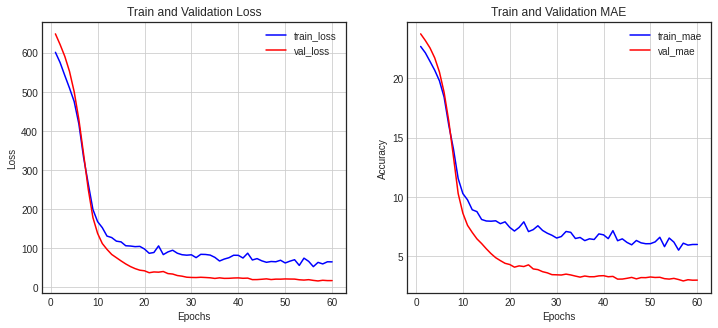

In [47]:
# 모델 학습 히스토리에서 loss, val_loss, mae, val_mae를 차트로 보여줍니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

mae = history_dict['mae']
val_mae = history_dict['val_mae']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, mae, 'b-', label='train_mae')
ax2.plot(epochs, val_mae, 'r-', label='val_mae')
ax2.set_title('Train and Validation MAE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

ㄴ validation 결과가 비교적 안정적이게 나온 것을 확인하였다.

## 4. 모델 평가 및 예측

In [48]:
# test셋에 대한 loss와 mae
model.evaluate(test_data, test_labels)

4/4 [==============================] - 0s 2ms/step - loss: 22.9142 - mae: 3.4872


[22.914241790771484, 3.487226963043213]

#### test 셋의 집값의 분산을 모델이 얼마만큼 설명하였는지 R-squared 지표로 확인

In [51]:
from sklearn.metrics import r2_score

# 1. 예측값을 구한다.
pred = model.predict(test_data)

# 2. R-squared 확인
r2_score(test_labels, pred)

0.724733484627232

In [52]:
# 원래 test 셋의 y값 분산
test_labels.var()

83.24384851980008

### 결과 해석 및 인사이트
1. 원래 test 데이터의 타겟값인 집값의 분산은 83이고, 모델의 예측에 따른 mse는 23이다. 이는 원래 데이터의 불확실성을 모델을 통해 83에서 23로 줄인 것으로, 모델이 집값예측에 유효함을 의미한다.


2. 그 유효함 정도를 R-squared 지표로 평가했을 때, r2_score 는 0.72로 모델이 실제 y값의 분산을 약 72% 설명한 것으로 나타났다.


3. 결과적으로 위 신경망 모델을 활용했을 때 그렇지 않은 경우보다 집값을 예측하는 불확실성을 약 72% 줄일 있다.

# Reuters 딥러닝 모델

## 1. 데이터 로드 및 전처리

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

#### data split

In [61]:
# 문제 2-1: reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리합니다.
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, 
                                                    test_size=0.2, 
                                                    stratify=train_labels,
                                                    random_state=42)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇 개인지 출력합니다.
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(set(train_labels)))

7185
1797
2246
46


In [72]:
print(set(train_labels))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45}


#### data encoding

In [62]:
# 문제 2-2: 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행합니다.
def one_hot_encoding(data, dim=10000):
  results = np.zeros((len(data), dim))
  for i, d in enumerate(data):
    results[i, d] = 1.
  return results


x_train = one_hot_encoding(train_data)
x_val = one_hot_encoding(val_data)
x_test = one_hot_encoding(test_data)

# 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환합니다.
y_train = utils.to_categorical(train_labels)
y_val = utils.to_categorical(val_labels)
y_test = utils.to_categorical(test_labels)

In [63]:
# 인코딩 결과 확인
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

((7185, 10000),
 (1797, 10000),
 (2246, 10000),
 (7185, 46),
 (1797, 46),
 (2246, 46))

## 2. 모델 구성 및 컴파일

In [87]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.

# 1. 모델 구성. 타겟은 46개 class 분류이므로 unit은 46, 
# 은닉층의 활성화함수는 leaky relu, 최종 활성화함수는 softmax로 설정
model = models.Sequential()
model.add(layers.Input(shape=(x_train.shape[1], )))
model.add(layers.Dense(2056))
model.add(layers.BatchNormalization())
model.add(layers.Activation('leaky_relu'))
model.add(layers.Dense(1028))
model.add(layers.BatchNormalization())
model.add(layers.Activation('leaky_relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512))
model.add(layers.BatchNormalization())
model.add(layers.Activation('leaky_relu'))
model.add(layers.Dense(256))
model.add(layers.BatchNormalization())
model.add(layers.Activation('leaky_relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128))
model.add(layers.BatchNormalization())
model.add(layers.Activation('leaky_relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(46, activation='softmax'))
model.summary()

# 2. 모델 컬파일. 원핫인코딩 다중분류이므로 loss - categorical_crossentropy,
# 옵티마이져는 Adam, metrics는 accuracy로 설정
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 2056)              20562056  
_________________________________________________________________
batch_normalization_20 (Batc (None, 2056)              8224      
_________________________________________________________________
activation_18 (Activation)   (None, 2056)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 1028)              2114596   
_________________________________________________________________
batch_normalization_21 (Batc (None, 1028)              4112      
_________________________________________________________________
activation_19 (Activation)   (None, 1028)              0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 1028)            

In [88]:
# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.

# 1. validation 결과가 가장 좋은 모델 저장
check_point_cb = callbacks.ModelCheckpoint('reuters_classification_model.h5', 
                                           save_best_only=True)

# 2. validation loss를 기준으로 early stopping 적용
early_stopping_cb = callbacks.EarlyStopping(patience=10, 
                                            monitor='val_loss',
                                            restore_best_weights=True)

# 3. 모델 학습. 배치 사이즈 64
history = model.fit(x_train, y_train, epochs=60,
                     batch_size=64, validation_data=(x_val, y_val),
                     callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/60
113/113 [==============================] - 3s 14ms/step - loss: 1.7462 - accuracy: 0.6206 - val_loss: 1.3451 - val_accuracy: 0.7023
Epoch 2/60
113/113 [==============================] - 1s 11ms/step - loss: 0.9787 - accuracy: 0.7797 - val_loss: 1.0842 - val_accuracy: 0.7668
Epoch 3/60
113/113 [==============================] - 1s 11ms/step - loss: 0.6973 - accuracy: 0.8386 - val_loss: 0.9943 - val_accuracy: 0.7869
Epoch 4/60
113/113 [==============================] - 1s 11ms/step - loss: 0.5273 - accuracy: 0.8736 - val_loss: 0.9890 - val_accuracy: 0.8002
Epoch 5/60
113/113 [==============================] - 1s 11ms/step - loss: 0.4139 - accuracy: 0.9002 - val_loss: 0.9663 - val_accuracy: 0.8047
Epoch 6/60
113/113 [==============================] - 1s 11ms/step - loss: 0.3362 - accuracy: 0.9175 - val_loss: 1.0096 - val_accuracy: 0.8075
Epoch 7/60
113/113 [==============================] - 1s 10ms/step - loss: 0.2685 - accuracy: 0.9329 - val_loss: 1.0317 - val_accuracy: 0.8052

#### 결과 시각화

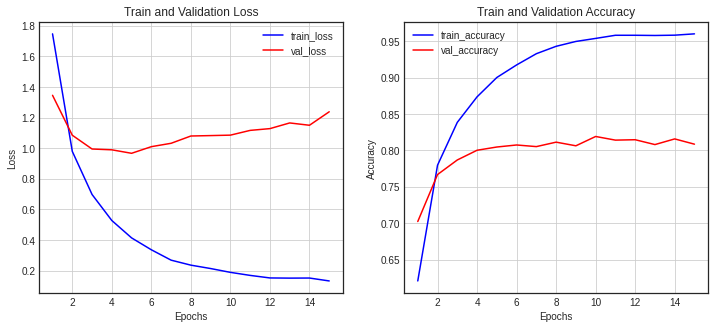

In [89]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

#### ㄴ 이전보다 validation 정확도가 80%를 약간 넘는 향상이 이루어졌다

## 3. 모델 평가 및 예측

In [90]:
# test셋에 대한 loss와 accuracy
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 3ms/step - loss: 1.0928 - accuracy: 0.7898


[1.0927598476409912, 0.7898486256599426]

### 분류 보고서 확인

In [91]:
from sklearn.metrics import classification_report
# 1. 예측 확률값
pred = model.predict(x_test)

# 2. 레이블 정보
class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
 'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
 'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
 'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
 'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

# 2. 분류 보고서 확인
print(classification_report(np.argmax(y_test, axis=-1), 
                            np.argmax(pred, axis=-1), 
                            target_names=class_names))

                 precision    recall  f1-score   support

          cocoa       0.75      0.75      0.75        12
          grain       0.73      0.60      0.66       105
        veg-oil       0.62      0.75      0.68        20
           earn       0.94      0.94      0.94       813
            acq       0.84      0.89      0.86       474
          wheat       0.00      0.00      0.00         5
         copper       0.52      0.93      0.67        14
        housing       1.00      0.33      0.50         3
   money-supply       0.61      0.74      0.67        38
         coffee       0.83      0.80      0.82        25
          sugar       0.58      0.97      0.72        30
          trade       0.59      0.80      0.68        83
       reserves       0.50      0.23      0.32        13
           ship       0.57      0.62      0.60        37
         cotton       1.00      0.50      0.67         2
        carcass       0.50      0.11      0.18         9
          crude       0.65    

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 히트맵 시각화

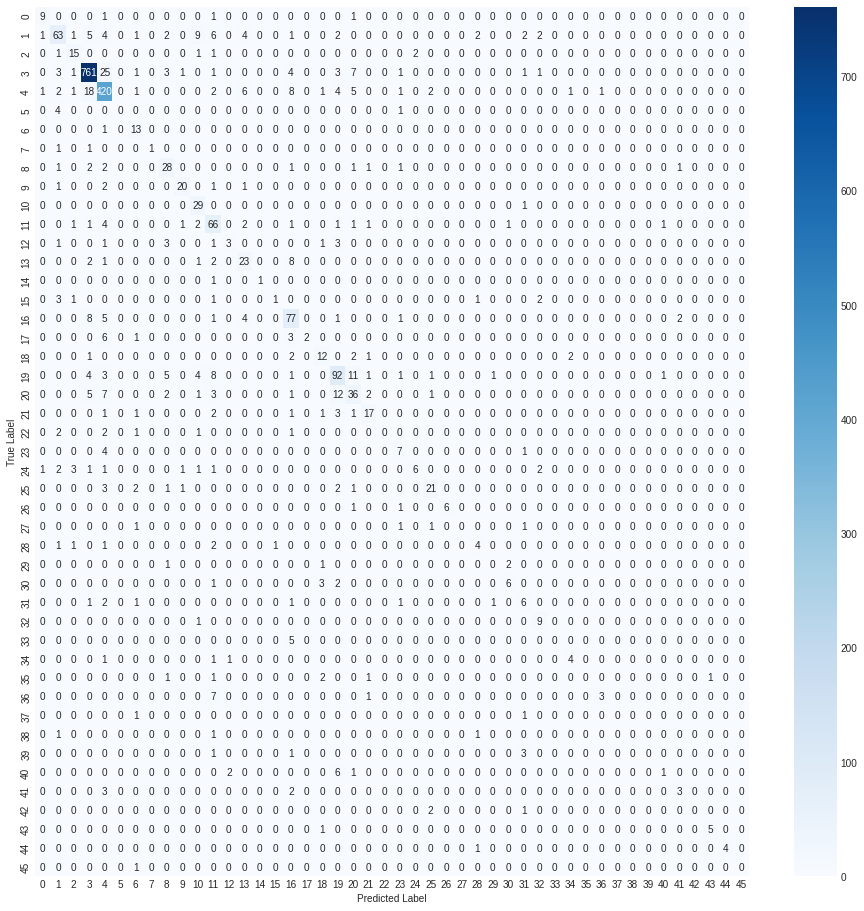

In [92]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(16, 16))
cm2 = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(pred, axis=-1))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 결과 해석 및 인사이트
1. 클래스가 46개이므로 히트맵을 시각화하는 것은 적절하지 않아 보인다.


2. test 데이터셋 레이블의 support를 보면 데이터가 불균형한 것을 확인할 수 있다. 30번 중후반대 클래스에 하나도 맞추지 못한 경우가 많이 많이 발생하였다. 따라서 정확도는 0.8임에도 평균의 평균인 macro avg는 0.48로 나타났다. f1 score 또한 support가 높은 클래스보다 낮은 클래스가 더 낮게 나타났다.


3. 결과적으로 데이터의 불균형으로 인한 성능의 한계를 확인하였다. MLP모델보다 자연어 처리에 적합한 아키텍쳐를 활용하는 것으로 성능 향상을 기대할 수 있겠다.


4. 그럼에도 불구하고 units의 수를 늘려 더 복잡한 dense 레이어를 구성하여 실험하였다. 예측 정확도는 오히려 70초중반으로 하락하거나, macor avg 가 0.5 내외로 소폭 상승하였다. 해당 테스크에 대하여 MLP 모델로 성능향상을 기대하기 어려웠다.

# CIFAR10 딥러닝 모델

## 1. 데이터 로드 및 전처리

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras.datasets import cifar10

In [2]:
# 문제 3-1: cifar10 데이터셋을 로드하고, 훈련 데이터셋에서 20%를 검증 데이터셋으로 분리합니다.
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, 
                                                    test_size=0.2, 
                                                    stratify=y_train_full,
                                                    random_state=42)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇개인지 출력합니다.
print("전체 학습 데이터: {} 레이블: {}".format(x_train_full.shape, y_train_full.shape))
print("학습 데이터: {} 레이블: {}".format(x_train.shape, y_train.shape))
print("검증 데이터: {} 레이블: {}".format(x_val.shape, y_val.shape))
print("테스트 데이터: {} 레이블: {}".format(x_test.shape, y_test.shape))

전체 학습 데이터: (50000, 32, 32, 3) 레이블: (50000, 1)
학습 데이터: (40000, 32, 32, 3) 레이블: (40000, 1)
검증 데이터: (10000, 32, 32, 3) 레이블: (10000, 1)
테스트 데이터: (10000, 32, 32, 3) 레이블: (10000, 1)


In [3]:
y_train

array([[6],
       [7],
       [8],
       ...,
       [1],
       [9],
       [3]], dtype=uint8)

In [4]:
type(x_train_full)

numpy.ndarray

In [3]:
# cifar10의 분류에 해당하는 'airplane', 'automobile', 'bird', 'cat', 'deer', 
# 'dog', 'frog', 'horse', 'ship', 'truck'를 class_name으로 정의합니다.
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

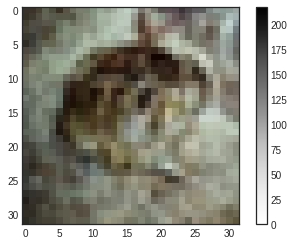

In [6]:
# 훈련 데이터의 0번째인 x_train[0]를 이미지로 시각화합니다.
plt.style.use('seaborn-white')

plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.show()

In [7]:
# 훈련, 검증, 테스트 데이터의 형태(shape)을 출력합니다.
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [4]:
# 훈련, 검증, 테스트 데이터를 255로 나누어 0~1 사이의 값으로 변환합니다.
x_train = x_train / 255.
x_val = x_val / 255.
x_test = x_test / 255.

In [9]:
# 문제 3-2: 훈련, 검증, 테스트 데이터의 형태(shape)을 32 * 32 * 3 = 3072로 변형합니다.
x_train_rs = x_train.reshape(40000, -1)
x_val_rs = x_val.reshape(10000, -1)
x_test_rs = x_test.reshape(10000, -1)

print(x_train_rs.shape)
print(x_val_rs.shape)
print(x_test_rs.shape)

(40000, 3072)
(10000, 3072)
(10000, 3072)


In [5]:
## 레이블 원핫인코딩 수행
from tensorflow.keras import utils

def one_hot_encoding(data, dim=10000):
  results = np.zeros((len(data), dim))
  for i, d in enumerate(data):
    results[i, d] = 1.
  return results

y_train = utils.to_categorical(y_train)
y_val = utils.to_categorical(y_val)
y_test = utils.to_categorical(y_test)

y_train.shape, y_val.shape, y_test.shape

((40000, 10), (10000, 10), (10000, 10))

## 2. 모델 구성 및 컴파일

In [12]:
# 문제 3-3: BatchNormalization과 Dropout을 적용하여 빠른 학습과 과대적합을 방지하고,
# 10개의 이미지를 분류하는 딥러닝 모델을 구성합니다.
model = models.Sequential()
model.add(layers.Input(shape=(x_train_rs.shape[1], )))
model.add(layers.Dense(2056))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dense(1028))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dense(256))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

# 2. 컴파일. 원핫인코딩 다중분류이므로 loss - categorical_crossentropy,
# 옵티마이져는 Adam, metrics는 accuracy로 설정
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2056)              6318088   
_________________________________________________________________
batch_normalization (BatchNo (None, 2056)              8224      
_________________________________________________________________
activation (Activation)      (None, 2056)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1028)              2114596   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1028)              4112      
_________________________________________________________________
activation_1 (Activation)    (None, 1028)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1028)              0

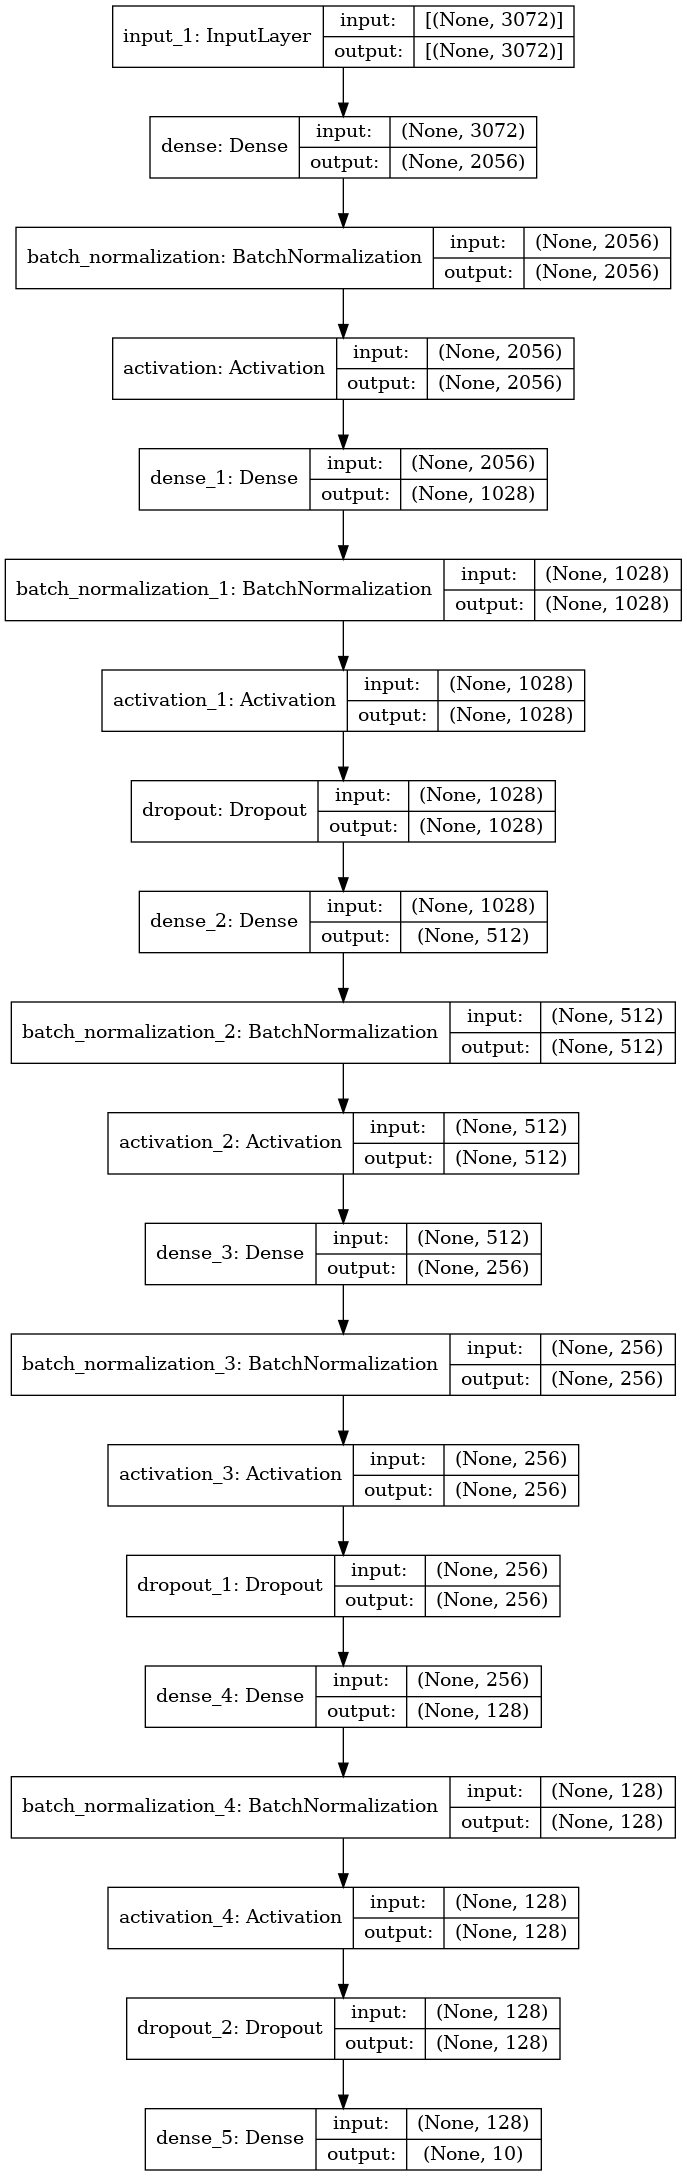

In [13]:
utils.plot_model(model, show_shapes=True)

## 3. 모델 학습

In [15]:
# 문제 3-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
from tensorflow.keras import callbacks

# 1. validation 결과가 가장 좋은 모델 저장
check_point_cb = callbacks.ModelCheckpoint('cifar10_mlp_model.h5', 
                                           save_best_only=True)

# 2. validation loss를 기준으로 early stopping 적용
early_stopping_cb = callbacks.EarlyStopping(patience=10, 
                                            monitor='val_loss',
                                            restore_best_weights=True)

# 3. 모델 학습. 배치 사이즈 64
history = model.fit(x_train_rs, y_train, epochs=60,
                     batch_size=64, validation_data=(x_val_rs, y_val),
                     callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/60
625/625 [==============================] - 16s 7ms/step - loss: 2.0195 - accuracy: 0.2864 - val_loss: 2.0384 - val_accuracy: 0.2901
Epoch 2/60
625/625 [==============================] - 4s 6ms/step - loss: 1.6711 - accuracy: 0.4059 - val_loss: 1.7383 - val_accuracy: 0.3738
Epoch 3/60
625/625 [==============================] - 4s 6ms/step - loss: 1.5616 - accuracy: 0.4507 - val_loss: 1.6234 - val_accuracy: 0.4145
Epoch 4/60
625/625 [==============================] - 4s 6ms/step - loss: 1.4863 - accuracy: 0.4780 - val_loss: 1.5082 - val_accuracy: 0.4617
Epoch 5/60
625/625 [==============================] - 4s 6ms/step - loss: 1.4223 - accuracy: 0.4993 - val_loss: 1.5951 - val_accuracy: 0.4315
Epoch 6/60
625/625 [==============================] - 4s 6ms/step - loss: 1.3695 - accuracy: 0.5219 - val_loss: 1.9417 - val_accuracy: 0.3289
Epoch 7/60
625/625 [==============================] - 4s 6ms/step - loss: 1.3249 - accuracy: 0.5367 - val_loss: 1.7146 - val_accuracy: 0.3848
Epoch

### 학습 히스토리 시각화

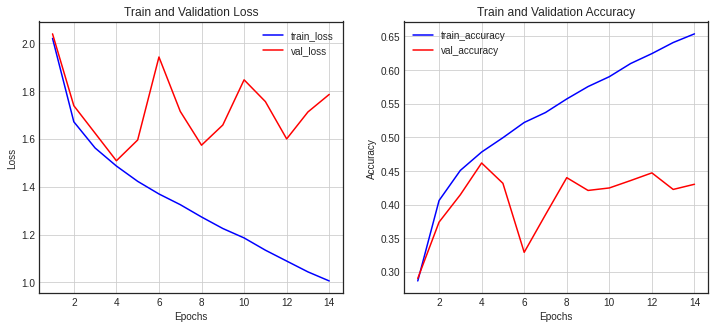

In [16]:
# 문제 3-5: 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

## 4. 모델 평가 및 예측

In [17]:
# test셋에 대한 loss와 accuracy
model.evaluate(x_test_rs, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.4983 - accuracy: 0.4662


[1.4982563257217407, 0.46619999408721924]

### 분류 보고서 확인

In [19]:
from sklearn.metrics import classification_report
import numpy as np

# 1. 예측 확률값
pred = model.predict(x_test_rs)

# 2. 분류 보고서 확인
print(classification_report(np.argmax(y_test, axis=-1), 
                            np.argmax(pred, axis=-1), 
                            target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.56      0.46      0.50      1000
  automobile       0.66      0.52      0.58      1000
        bird       0.45      0.14      0.21      1000
         cat       0.34      0.27      0.30      1000
        deer       0.43      0.36      0.39      1000
         dog       0.43      0.34      0.38      1000
        frog       0.42      0.71      0.52      1000
       horse       0.48      0.56      0.52      1000
        ship       0.50      0.66      0.57      1000
       truck       0.44      0.65      0.52      1000

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.45     10000
weighted avg       0.47      0.47      0.45     10000



### 히트맵 시각화

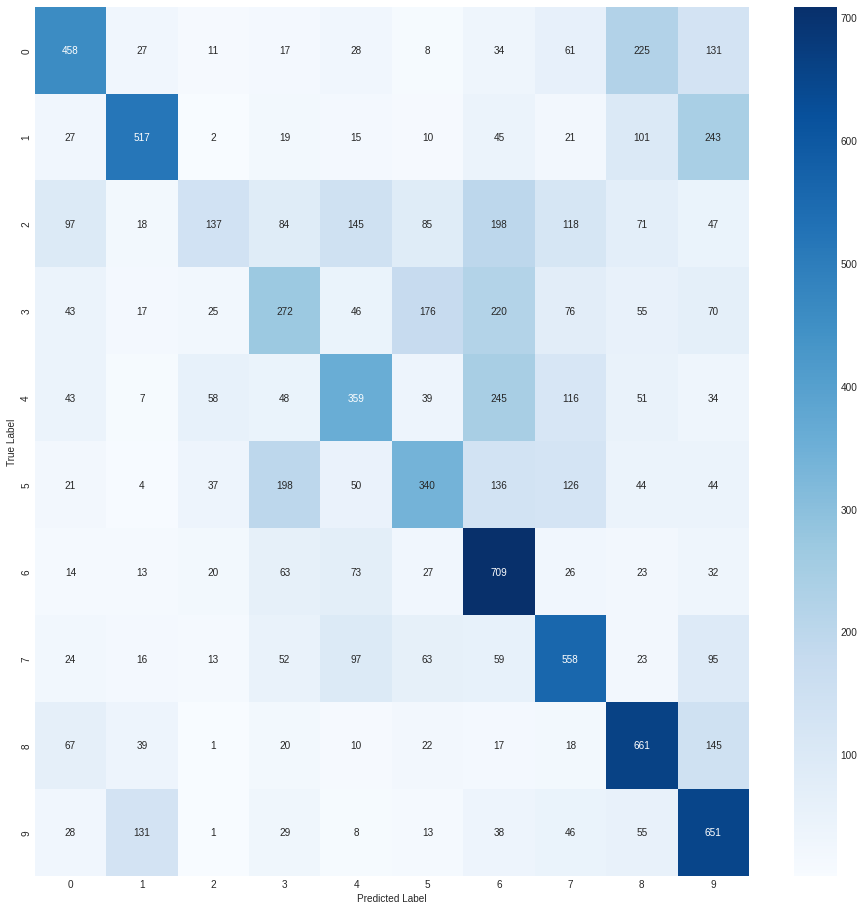

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(16, 16))
cm2 = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(pred, axis=-1))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 결과 해석 및 인사이트
1. 2, 3, 5 레이블 - 새, 고양이, 개 순으로 f1 스코어가 낮게 나왔다.

2. 모델이 4, 6 레이블 - 사슴, 개구리를 가장 헷깔려한 것으로 나타났다.

3. 정확도는 0.47, marco avg는 0.45로, 전체적으로 50%에 미치지 않는 정확도가 나왔다.

4. CNN 모델로 성능이 얼마나 개선되는지 실험하였다.

# + CNN 모델링 - 아키텍쳐 변화에 따른 성능 향상

## 1. 데이터 확인

In [21]:
# reshape 하지 않은 원래 데이터
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [25]:
# 정규화 상태 확인
x_train[0][0]

array([[0.21960784, 0.19607843, 0.16470588],
       [0.23137255, 0.2       , 0.16078431],
       [0.2745098 , 0.25490196, 0.2       ],
       [0.37647059, 0.38823529, 0.31764706],
       [0.30588235, 0.30588235, 0.24313725],
       [0.21568627, 0.18823529, 0.1372549 ],
       [0.34509804, 0.3254902 , 0.27058824],
       [0.43137255, 0.43137255, 0.36862745],
       [0.47843137, 0.49411765, 0.42745098],
       [0.46666667, 0.49803922, 0.42745098],
       [0.51372549, 0.57254902, 0.49803922],
       [0.60392157, 0.6627451 , 0.59215686],
       [0.57647059, 0.61568627, 0.55686275],
       [0.63529412, 0.6745098 , 0.61960784],
       [0.71372549, 0.76470588, 0.71372549],
       [0.75294118, 0.81568627, 0.76470588],
       [0.68235294, 0.71372549, 0.68235294],
       [0.48235294, 0.46666667, 0.43529412],
       [0.60392157, 0.58823529, 0.54509804],
       [0.4745098 , 0.48235294, 0.43921569],
       [0.34117647, 0.31764706, 0.30196078],
       [0.36078431, 0.31372549, 0.3254902 ],
       [0.

## 2. CNN 모델 구성 및 컴파일

In [26]:
# 1. CNN 모델 구성
model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(32, 32, 3)))
model_cnn.add(layers.MaxPool2D(2,2))
model_cnn.add(layers.Conv2D(8, (3,3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2,2)))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(32, activation='relu'))
model_cnn.add(layers.Dense(10, activation='softmax'))
model_cnn.summary()

# 2. 컴파일. 원핫인코딩 다중분류이므로 loss - categorical_crossentropy,
# 옵티마이져는 Adam, metrics는 accuracy로 설정
model_cnn.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 288)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                9248      
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

## 3. 학습

In [27]:
from tensorflow.keras import callbacks

# 1. validation 결과가 가장 좋은 모델 저장
check_point_cb = callbacks.ModelCheckpoint('cifar10_cnn_model.h5', 
                                           save_best_only=True)

# 2. validation loss를 기준으로 early stopping 적용
early_stopping_cb = callbacks.EarlyStopping(patience=10, 
                                            monitor='val_loss',
                                            restore_best_weights=True)

# 3. 모델 학습. 배치 사이즈 64
history = model_cnn.fit(x_train, y_train, epochs=60,
                     batch_size=64, validation_data=(x_val, y_val),
                     callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/60
625/625 [==============================] - 38s 11ms/step - loss: 1.8047 - accuracy: 0.3421 - val_loss: 1.5741 - val_accuracy: 0.4297
Epoch 2/60
625/625 [==============================] - 2s 4ms/step - loss: 1.5064 - accuracy: 0.4542 - val_loss: 1.4566 - val_accuracy: 0.4772
Epoch 3/60
625/625 [==============================] - 2s 4ms/step - loss: 1.4234 - accuracy: 0.4897 - val_loss: 1.4400 - val_accuracy: 0.4879
Epoch 4/60
625/625 [==============================] - 2s 4ms/step - loss: 1.3612 - accuracy: 0.5118 - val_loss: 1.3695 - val_accuracy: 0.5093
Epoch 5/60
625/625 [==============================] - 2s 4ms/step - loss: 1.3219 - accuracy: 0.5265 - val_loss: 1.3241 - val_accuracy: 0.5284
Epoch 6/60
625/625 [==============================] - 2s 4ms/step - loss: 1.2853 - accuracy: 0.5450 - val_loss: 1.3058 - val_accuracy: 0.5398
Epoch 7/60
625/625 [==============================] - 2s 4ms/step - loss: 1.2602 - accuracy: 0.5511 - val_loss: 1.2690 - val_accuracy: 0.5484
Epoc

### 학습 히스토리 시각화

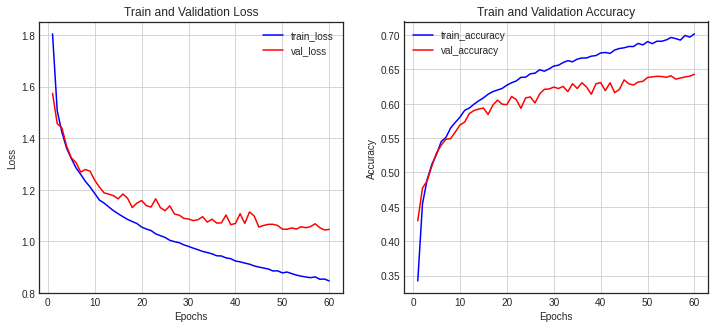

In [28]:
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

## 4. 결과 확인

In [31]:
# test셋에 대한 loss와 accuracy
model_cnn.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.0318 - accuracy: 0.6496


[1.0318374633789062, 0.6496000289916992]

### 분류 보고서 확인

In [6]:
# load_model을 통한 cnn 모델 불러오기
model_cnn = models.load_model('cifar10_cnn_model.h5')

#### ㄴ중간에 커널이 죽었지만 저장한 모델 불러오기 !!!

In [7]:
from sklearn.metrics import classification_report
import numpy as np

# 1. 예측 확률값
pred = model_cnn.predict(x_test)

# 2. 분류 보고서 확인
print(classification_report(np.argmax(y_test, axis=-1), 
                            np.argmax(pred, axis=-1), 
                            target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.71      0.66      0.68      1000
  automobile       0.73      0.77      0.75      1000
        bird       0.51      0.51      0.51      1000
         cat       0.48      0.41      0.44      1000
        deer       0.59      0.61      0.60      1000
         dog       0.56      0.56      0.56      1000
        frog       0.72      0.76      0.74      1000
       horse       0.65      0.76      0.70      1000
        ship       0.75      0.74      0.75      1000
       truck       0.75      0.69      0.72      1000

    accuracy                           0.65     10000
   macro avg       0.65      0.65      0.65     10000
weighted avg       0.65      0.65      0.65     10000



### 히트맵 시각화

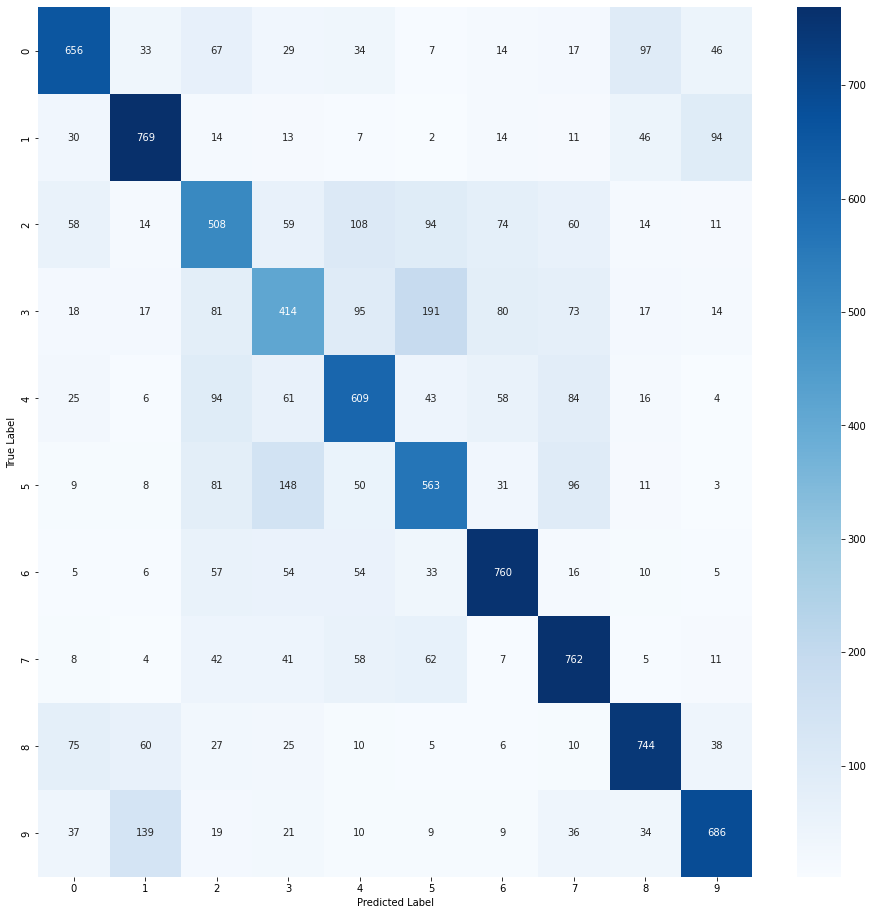

In [8]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(16, 16))
cm2 = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(pred, axis=-1))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 결과 해석 및 인사이트
1. 이전 MLP 모델에 비해 간단하게 모델링한 CNN 모델의 정확도가 0.47 에서 0.65 로 향상되었다.


2. CNN 모델은 고양이(3)와 개(5)를 구분하는 부분에서 성능이 낮게 나타났다.


3. 학습 히스토리를 확인해보면, CNN 모델이 MLP 모델보다 학습과정이 안정적으로 나타났다.


4. CNN 모델은 3x3 컨볼루션을 활용했는데, 이는 2D 데이터의 2차원 특징을 추출한다는 점에서 이미지 분류 테스크에 MLP 모델보다 더 나은 성능을 나타낸다.

# 회고
- 모델을 개선할 수 있는 점
1. CNN 모델 학습과정을 보면 오버피팅이 발생한 것으로 보인다. dropout과 batch normalization 방법을 활용하여 validation 결과를 개선하는 시도를 해볼 수 있다.
2. 레이어와 unit을 추가하여 데이터의 특정을 더 세부적이게 학습하게 하여 데이터에 좀더 fit한 모델링을 시도할 수 있다.

- 배운 점
1. 레이블을 원핫인코딩한 경우 손실함수로 sparse_categorical_crossentropy 가 아닌 categorical_crossentropy 함수를 사용해야 하는 점을 확인했다. 두 손실함수의 차이에 대해 추후 더 공부해야 할 것 같다.
2. CIFAR10 실습에서 레이블 데이터를 원핫인코딩하는 부분이 생략된 것을 발견했다. 오류가 발생하는 부분에서 원핫인코딩을 수행하여 문제해결을 하였다.

- 느낀 점
1. 모델링을 할 때 레이블과 유닛, 손실함수, 옵티마이져, 아키텍쳐 구성 등 어떻게 해야 할지 막연했었다. 머신러닝에서는 CV방법으로 계산할 수 있었지만 딥러닝에서는 어떻게 해야할지 앞으로 더 공부하면서 질문에 대한 답을 찾고자 한다.
2. 지금까지 배운 것을 바탕으로 실제 데이터에 대해서도 모델링을 시도해볼 수 있을 것 같다. 예전에 혼자 공부할 때 막연하게 넘어갔던 부분들을 - 모델 저장, 콜백, 옵티마이져 등 - 정리할 수 있어서 많은 도움이 되었다.